In [50]:
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt

# from plotly import graph_objects as go
# from plotly import io as pio
import sys

sys.path.append("..")
import Final_nn_classes as nn
import io_util

print(sys.version)

# pio.templates.default = "plotly_dark"

3.12.7 (main, Nov 30 2024, 14:30:56) [GCC 13.2.0]


In [51]:
reload(nn)
reload(io_util)

data = io_util.load_mnist("..", maximum=(5_000, 10_000, 10_000))
print(data)


MnistDataSet
  train  -> X: (5000, 784) float32 | Y: (5000,) int64
  val    -> X: (10000, 784) float32 | Y: (10000,) int64
  test   -> X: (10000, 784) float32 | Y: (10000,) int64



Testing architecture: [16]
Train DL: 5000 samples = 156 batches x 32
Val   DL: 10000 samples = 1 batches x 10000
epoch=   9 | loss_mean_train=0.0172 | loss_mean_val=0.0243 | samples/second 21992 | acc_val=76.4% | lr: 0.1
Best accuracy: 0.764

Testing architecture: [32]
Train DL: 5000 samples = 156 batches x 32
Val   DL: 10000 samples = 1 batches x 10000
epoch=   9 | loss_mean_train=0.0160 | loss_mean_val=0.0210 | samples/second 14623 | acc_val=83.3% | lr: 0.1
Best accuracy: 0.833

Testing architecture: [16, 16]
Train DL: 5000 samples = 156 batches x 32
Val   DL: 10000 samples = 1 batches x 10000
epoch=   9 | loss_mean_train=0.0271 | loss_mean_val=0.0281 | samples/second 28697 | acc_val=66.3% | lr: 0.1
Best accuracy: 0.671

Best architecture: [32] (acc: 0.833)
{'arch': [16], 'accuracy': np.float64(0.7642)}
{'arch': [32], 'accuracy': np.float64(0.8334)}
{'arch': [16, 16], 'accuracy': np.float64(0.6709)}

Testing learning rate: 0.01
Train DL: 5000 samples = 156 batches x 32
Val   DL: 100

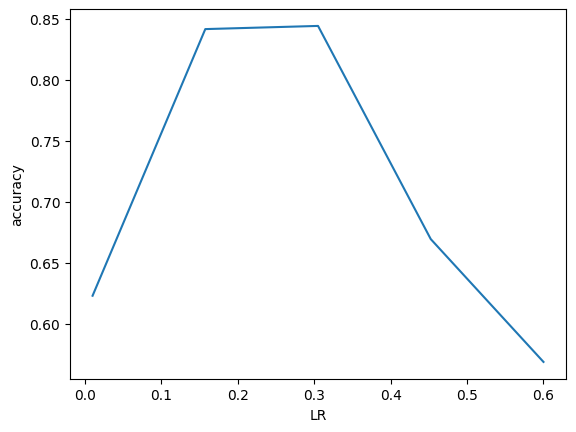

In [52]:
from Final import hyper

reload(hyper)
study = hyper.HyperparamStudy(data, 10)

res_a = study.test_architecture(
    [
        [16],
        [32],
        [16, 16],
    ]
)
for r in res_a:
    print(r)

res_lr = study.test_learning_rates(np.linspace(0.01, 0.6, 5).tolist())

plt.plot(
    [r["lr"] for r in res_lr],
    [r["accuracy"] for r in res_lr],
)
plt.ylabel("accuracy")
plt.xlabel("LR")
plt.show()

In [53]:
import optuna


study = optuna.load_study(
    study_name="FFN_1hidden_5000tr",  # small data, many trials
    # study_name="FFN_1hidden_50000tr",  # all data, few trials
    storage="sqlite:///../data/optuna.db",
)
df = study.trials_dataframe()
df = df.loc[df["state"] == "COMPLETE"]
print("best params", study.best_params)
print(
    f"best val acc: {df['value'].max():.2%}",
)
df.tail(3)

best params {'loss_mode': 'mse', 'act_fn_hidden': 'sigmoid', 'hidden_size0': 70, 'bs': 96, 'start_lr': 3.009681287282161}
best val acc: 93.83%


,number,value,datetime_start,datetime_complete,duration,params_act_fn_hidden,params_bs,params_hidden_size0,params_loss_mode,params_start_lr,user_attrs_acc_test,user_attrs_loss_test,user_attrs_n_lr_steps,state
12,12,0.9383,2025-09-18 10:08:16.071776,2025-09-18 10:10:03.033908,0 days 00:01:46.962132,sigmoid,96,70,mse,3.009681,0.9335,0.005680,2.0,COMPLETE
13,13,0.9363,2025-09-18 10:10:03.091924,2025-09-18 10:11:56.065880,0 days 00:01:52.973956,sigmoid,96,72,mse,2.986601,0.9327,0.005708,2.0,COMPLETE
15,15,0.9364,2025-09-18 10:45:01.738942,2025-09-18 10:46:22.280785,0 days 00:01:20.541843,sigmoid,64,73,mse,1.817250,0.9325,0.005824,2.0,COMPLETE


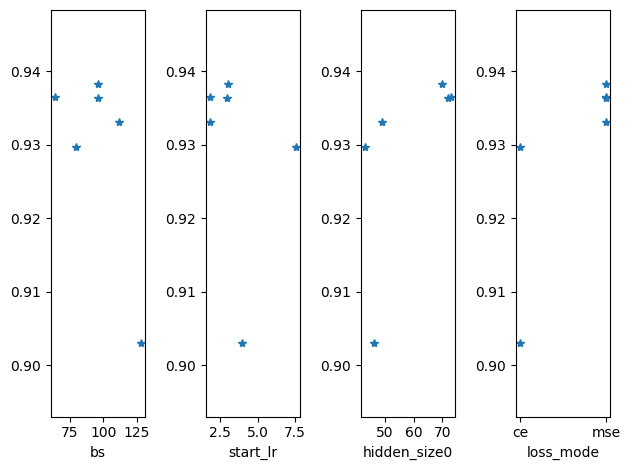

In [54]:
params = [
    "bs",
    "start_lr",
    "hidden_size0",
    "loss_mode",
]
for i, p in enumerate(params):
    plt.subplot(1, len(params), i + 1)
    plt.plot(df[f"params_{p}"], df["value"], "*")
    plt.xlabel(p)
    plt.ylim(df["value"].min() - 0.01, df["value"].max() + 0.01)
plt.tight_layout()


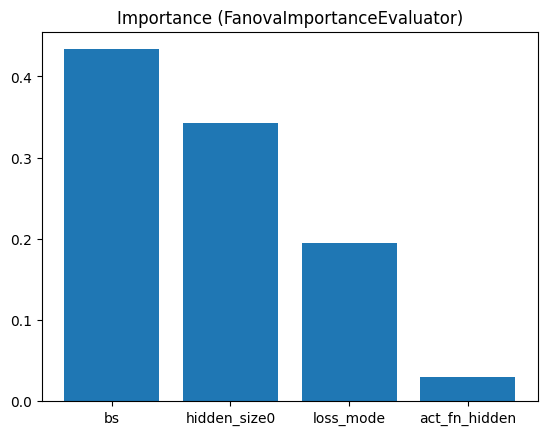

In [55]:
from optuna import importance

eval = importance.FanovaImportanceEvaluator()
imp = importance.get_param_importances(study, evaluator=eval)
plt.bar(list(imp.keys()), list(imp.values()))
plt.title(f"Importance ({type(eval).__name__})")
plt.show()